# Ultimate Refriz Frames Project

## Data importing and cleaning
(To see associated experimental stimuli script, [go here](https://bitbucket.org/smweis/frizrf/overview)
We import the necessary modules, and one custom function that wraps up data importing.


In [6]:
#Load and clean data.

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import statsmodels.api as sm
import os
#import statsmodels.formula.api as smf

#custom function to import data: See here: https://github.com/smweis/Ultimate
from importData import getData

#change path to wherever you downloaded the data. You'll need to download 2 folders and one file:
# friz_clean, nav_clean, and additionalData_For_Python.xlsx

import os
path = os.getcwd()

path = path + '\\data\\'


#Get Data
frizData = getData(path + 'friz_clean')
navData = getData(path+ 'nav_clean')
additionalData = pd.read_excel(path+ 'additionalData_For_Python.xlsx',header=0)
#Recode "psychopycode to participant"
additionalData['participant'] = additionalData['psychopycode']

#Clean data functions
def removeHighRTs(howManySDs,dv,data): 
    ### dv should be a reaction time variable within data.
    if howManySDs == 0:
        return data
    rtThresh = howManySDs*np.std(data[dv]) #calculate Std. deviation
    rtMean = np.mean(data[dv]) #calculate mean
    dataThresh = data.loc[data[dv] < (rtMean + rtThresh)] #select only data that is less than the mean + the num of SDs specified
    dataThresh = dataThresh.loc[dataThresh[dv] > 0] # remove any weird answers above 0
    return dataThresh


def removeWrongAnswers(dv,data):
    dataCorrect = data.loc[data[dv] == 1]
    return dataCorrect


def renameFactorLevels(data,friz_or_nav):
    data['condition'] = friz_or_nav
    prompts = sorted(data.prompt1.unique())
    stims = sorted(data.stim1.unique())
    new_stims = ['far_left','far_right','near_left','near_right']

    if friz_or_nav == 'friz':    
        new_prompts = ['Away','Left','Right','Home']
    else:
        new_prompts = ['Away','Home','Left','Right']
        
    for i in range(len(prompts)):
        data = data.replace(prompts[i],new_prompts[i])
        data = data.replace(stims[i],new_stims[i])
        
    return data


def newFactorPrompts(row):
    if row['prompt1'] == 'Home' or row['prompt1'] == 'Away':
        return 'Absolute'
    else:
        return 'Relative'

    
def newFactorStims(row):
    if row['stim1'] == 'near_right' or row['stim1'] == 'near_left':
        return 'Near'
    else:
        return 'Far'

    

#Rename conditions
frizData = renameFactorLevels(frizData,'Frisbee')
navData = renameFactorLevels(navData,'Navigation')
#Recode stimulus location to a binary variable.
frizData['stimLoc'] = frizData.apply(lambda row: newFactorStims(row),axis=1)
navData['stimLoc'] = navData.apply(lambda row: newFactorStims(row),axis=1)
#Recode prompt type to a binary variable. 
frizData['promptType'] = frizData.apply(lambda row: newFactorPrompts(row),axis=1)
navData['promptType'] = navData.apply(lambda row: newFactorPrompts(row),axis=1)


unthreshed_data = frizData.append(navData)

neccessaryAdditionalData = additionalData.loc[:,
                                              ["Sex","Age","participant",
                                               "SBSOD_AVERAGE",
                                               "Friz_Total_Years_Played",
                                               "Friz_Force_Preference",
                                               "Friz_Position"]]

  

## Weirdness in correct answers!

Before we continue, observe something strange. 

People are generally very good at this task....except for when it is a navigation task with a "Go Home" 
or "Go Away" prompt, and the navigator is on the far side of the screen.

It appears as though some people interpreted the "Go Home" question as turning in the direction that the navigator should turn, 
rather than the direction relative to the responder.

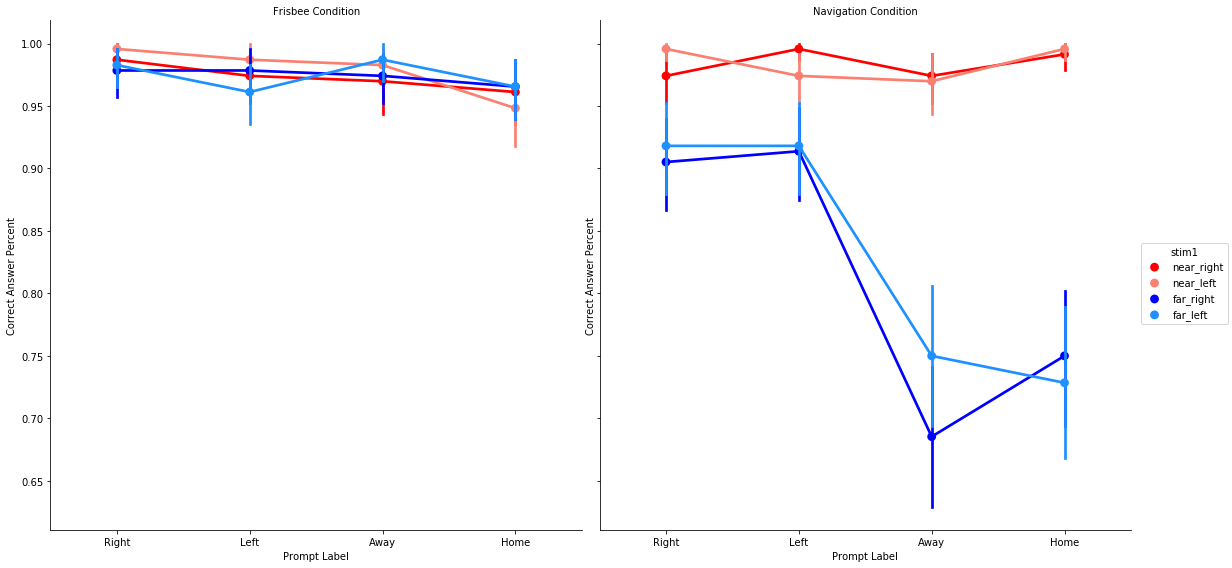

condition   stimLoc  promptType
Frisbee     Far      Absolute      15.568966
                     Relative      15.603448
            Near     Absolute      15.448276
                     Relative      15.775862
Navigation  Far      Absolute      11.655172
                     Relative      14.620690
            Near     Absolute      15.724138
                     Relative      15.758621
dtype: float64

In [4]:
#Correct answer strangeness!
pivotedCorrectAns = unthreshed_data.pivot_table(index='participant',columns=['condition','stimLoc','promptType'],
                                  values='Trials_responsecorr',aggfunc=np.sum)


ax2 = sns.factorplot(x = "prompt1", y = "Trials_responsecorr", data = unthreshed_data, hue = "stim1", palette=['red','salmon','blue','dodgerblue'],
                    kind = "point", size = 8,col='condition', order=['Right','Left','Away','Home'], hue_order=['near_right','near_left','far_right','far_left'])
ax2.set(xlabel='Prompt Label', ylabel='Correct Answer Percent')
ax2.set_titles("{col_name} Condition")

plt.show()



## Re-coding "correct" and who flipped that, and other data cleaning

A closer look reveals that about 1/3 of participants spontaneously answered the Absolute questions "backward" when the navigator was facing them! 

In [ ]:
display(pivotedCorrectAns)


### It turns out, there are a few differences between these groups. 

For one thing, flippers are much slower on Nav/Absolute/Far tasks compared to nonflippers.

For another thing, they are more likely to prefer referring to the force as "Force Home/Away."



In [33]:
#Differences between flippers and nonflippers


pivotedRT = unthreshed_data.pivot_table(index='participant',columns=['condition','stimLoc','promptType'],
                                  values='Trials_responsert',aggfunc=np.mean)
def addPivots(pivoted):
    pivoted['Frisbee_Rel_minus_Abs_Far'] = pivoted['Frisbee']['Far']['Relative'] - pivoted['Frisbee']['Far']['Absolute']
    pivoted['Frisbee_Rel_minus_Abs_Near'] = pivoted['Frisbee']['Near']['Relative'] - pivoted['Frisbee']['Near']['Absolute']
    pivoted['Frisbee_Rel_minus_Abs'] = (pivoted['Frisbee_Rel_minus_Abs_Far'] + pivoted['Frisbee_Rel_minus_Abs_Near'])/2
    pivoted['Nav_Rel_minus_Abs_Far'] = pivoted['Navigation']['Far']['Relative'] - pivoted['Navigation']['Far']['Absolute']
    pivoted['Nav_Rel_minus_Abs_Near'] = pivoted['Navigation']['Near']['Relative'] - pivoted['Navigation']['Near']['Absolute']
    pivoted['Nav_Rel_minus_Abs'] = (pivoted['Nav_Rel_minus_Abs_Far'] + pivoted['Nav_Rel_minus_Abs_Near'])/2
    
addPivots(pivotedRT)

a = pivotedCorrectAns[('Navigation','Far','Absolute')]< 8
flippersRT = pivotedRT[a]
nonflippersRT = pivotedRT[~a]
flippersCorr = pivotedCorrectAns[a]
nonflippersCorr = pivotedCorrectAns[~a]
                                 

display(flippersCorr)
t = []
p = []
for i,j in enumerate(flippersRT):
    if flippersRT[j].dtype == 'float64':
        t,p = scipy.stats.ttest_ind(flippersRT[j],nonflippersRT[j])
        jPrint = '{}, {}, {}:'.format(j[0],j[1],j[2])
        if p < .05:
            p = '{:.4f}'.format(p)
        else:
            p = '{:.2f}'.format(p)
        display('{} Flipper Mean = {:.2f}, NonFlipper Mean = {:.2f}, t = {:.2f}, p = {}'.format(jPrint,np.mean(flippersRT[j]),np.mean(nonflippersRT[j]),t,p))

if 'participant' in neccessaryAdditionalData.columns:
    neccessaryAdditionalData.set_index('participant',inplace=True)

neccessaryAdditionalData.index = neccessaryAdditionalData.index.map(str)
neccessaryAdditionalData.sort_index(inplace=True)
a.sort_index(inplace=True)

flippers = neccessaryAdditionalData[a]
nonflippers = neccessaryAdditionalData[~a]


display(flippers.groupby('Friz_Force_Preference')['Friz_Position'].count())
display(nonflippers.groupby('Friz_Force_Preference')['Friz_Position'].count())



flippersCorrNoNFA = flippersCorr.drop([('Navigation','Far','Absolute')],axis=1)
nonflippersCorrNoNFA = nonflippersCorr.drop([('Navigation','Far','Absolute')],axis=1)

x = flippersCorrNoNFA.drop([('Frisbee')],axis=1).mean(axis=1)
b = nonflippersCorrNoNFA.drop([('Frisbee')],axis=1).mean(axis=1)

tt,pp = scipy.stats.ttest_ind(x,b)
print(x.mean(),b.mean())
print(tt,pp)

condition    Frisbee                            Navigation                    \
stimLoc          Far              Near                 Far              Near   
promptType  Absolute Relative Absolute Relative   Absolute Relative Absolute   
participant                                                                    
26044874        16.0     15.0     16.0     16.0        1.0     15.0     15.0   
30426108        16.0     16.0     15.0     15.0        6.0     16.0     16.0   
34545091        16.0     16.0     15.0     16.0        5.0     15.0     16.0   
3771103         16.0     16.0     16.0     16.0        1.0     16.0     16.0   
38638936        16.0     13.0     13.0     15.0        5.0     13.0     14.0   
40321903        15.0     15.0     16.0     16.0        1.0     14.0     16.0   
44376975        10.0     11.0     16.0     15.0        3.0     16.0     15.0   
49320823        16.0     16.0     15.0     14.0        3.0     16.0     15.0   
52817250        16.0     16.0     14.0     15.0        4.0     16.0     16.0   
55421948        15.0     16.0     16.0     16.0        1.0     14.0     15.0   
56594642        16.0     16.0     16.0     16.0        3.0     16.0     16.0   
58799837        16.0     16.0     16.0     16.0        4.0     16.0     16.0   
61853264        15.0     16.0     13.0     16.0        4.0     16.0     16.0   
63506070        16.0     16.0     16.0     16.0        1.0     15.0     14.0   
6421150         16.0     16.0     16.0     16.0        1.0     14.0     15.0   
64490590        16.0     16.0     16.0     16.0        3.0     15.0     16.0   
68116738        16.0     16.0     16.0     16.0        1.0     16.0     16.0   

condition             
stimLoc               
promptType  Relative  
participant           
26044874        16.0  
30426108        16.0  
34545091        16.0  
3771103         16.0  
38638936        15.0  
40321903        16.0  
44376975        16.0  
49320823        16.0  
52817250        16.0  
55421948        16.0  
56594642        15.0  
58799837        15.0  
61853264        16.0  
63506070        16.0  
6421150         15.0  
64490590        16.0  
68116738        15.0

'Frisbee, Far, Absolute: Flipper Mean = 1.45, NonFlipper Mean = 1.27, t = 1.11, p = 0.27'

'Frisbee, Far, Relative: Flipper Mean = 1.30, NonFlipper Mean = 1.16, t = 0.97, p = 0.33'

'Frisbee, Near, Absolute: Flipper Mean = 1.33, NonFlipper Mean = 1.20, t = 1.07, p = 0.29'

'Frisbee, Near, Relative: Flipper Mean = 1.24, NonFlipper Mean = 1.10, t = 1.00, p = 0.32'

'Navigation, Far, Absolute: Flipper Mean = 1.58, NonFlipper Mean = 1.09, t = 3.53, p = 0.0008'

'Navigation, Far, Relative: Flipper Mean = 1.34, NonFlipper Mean = 1.38, t = -0.30, p = 0.76'

'Navigation, Near, Absolute: Flipper Mean = 1.01, NonFlipper Mean = 0.86, t = 2.05, p = 0.0449'

'Navigation, Near, Relative: Flipper Mean = 0.90, NonFlipper Mean = 0.93, t = -0.31, p = 0.76'

'Frisbee_Rel_minus_Abs_Far, , : Flipper Mean = -0.15, NonFlipper Mean = -0.11, t = -0.77, p = 0.44'

'Frisbee_Rel_minus_Abs_Near, , : Flipper Mean = -0.09, NonFlipper Mean = -0.10, t = 0.20, p = 0.84'

'Frisbee_Rel_minus_Abs, , : Flipper Mean = -0.12, NonFlipper Mean = -0.11, t = -0.22, p = 0.83'

'Nav_Rel_minus_Abs_Far, , : Flipper Mean = -0.23, NonFlipper Mean = 0.30, t = -5.59, p = 0.0000'

'Nav_Rel_minus_Abs_Near, , : Flipper Mean = -0.11, NonFlipper Mean = 0.07, t = -2.94, p = 0.0048'

'Nav_Rel_minus_Abs, , : Flipper Mean = -0.17, NonFlipper Mean = 0.18, t = -5.34, p = 0.0000'

Friz_Force_Preference
Forehand / Backhand     2
Home / Away            13
Name: Friz_Position, dtype: int64

Friz_Force_Preference
Forehand / Backhand    17
Home / Away            19
Name: Friz_Position, dtype: int64

15.470588235294118 15.325203252032518
0.8316525293729985 0.40913740051467806


In [30]:
#Reverse correct answers for flippers
a = flippers.index.values.tolist()
df = unthreshed_data
df['flipper'] = np.where(df.participant.isin(a),'flipper','nonflipper')

def f(df):
    if df['flipper'] == 'flipper' and df['condition'] == 'Navigation' and df['stimLoc'] == 'Far' and df['promptType'] == 'Absolute':
        if df['Trials_responsecorr'] == 1: return 0
        elif df['Trials_responsecorr'] == 0: return 1
    else:
        return df['Trials_responsecorr']
        

df['newCorrect'] = df.apply(f, axis=1)
df.Trials_responsecorr.mean()
df.newCorrect.mean()

0.9626885775862069

## So let's take a look at correct answers, with and without reversing the Flippers. 

                     condition 
Trials_responsecorr  Frisbee       0.974946
                     Navigation    0.902478
newCorrect           Frisbee       0.974946
                     Navigation    0.950431
dtype: float64

                     condition 
Trials_responsecorr  Frisbee       0.034125
                     Navigation    0.095708
newCorrect           Frisbee       0.034125
                     Navigation    0.039608
dtype: float64

Ttest_relResult(statistic=4.411235827444832, pvalue=4.618797659649235e-05)

Ttest_relResult(statistic=5.78436547432147, pvalue=3.234992305176474e-07)

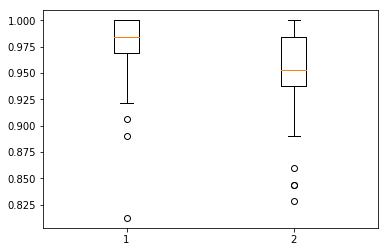

In [31]:
correctAnsByCond = unthreshed_data.pivot_table(index='participant',columns=['condition'],
                                  values=['Trials_responsecorr','newCorrect'],aggfunc=np.mean)

plt.boxplot([correctAnsByCond['newCorrect'].Frisbee,correctAnsByCond['newCorrect'].Navigation])

display(correctAnsByCond.mean(),correctAnsByCond.std())

display(scipy.stats.ttest_rel(correctAnsByCond['newCorrect'].Frisbee,correctAnsByCond['newCorrect'].Navigation))
display(scipy.stats.ttest_rel(correctAnsByCond['Trials_responsecorr'].Frisbee,correctAnsByCond['Trials_responsecorr'].Navigation))

### Now we'll choose which data to analyze moving forward. 
**reverse**: should 'flippers' have their scores reversed for Far-Absolute navigation trials?

**stdRtThreshold**: number of standard deviations to trim above the mean for RT

**justCorrect**: exclude wrong answers

In [ ]:
def chooseYourData(reverse=True,stdRtThreshold=2,justCorrect=True,dfp=df):
    ###default are the way the data are analyzed in the paper
    # reverse: should 'flippers' have their scores reversed for Far-Absolute navigation trials?
    # stdRtThreshold: number of standard deviations to trim above the mean for RT
    # justCorrect: exclude wrong answers
    if reverse: 
        dv_corr = 'newCorrect'
    else:
        dv_corr = 'Trials_responsecorr'
    if stdRtThreshold:
        dfp = removeHighRTs(stdRtThreshold,'Trials_responsert',dfp)
    if justCorrect:
        dfp = removeWrongAnswers(dv_corr, dfp)
        
    return dfp



dataForPlot = chooseYourData(justCorrect=True, reverse=True,stdRtThreshold=2)
print('Total trials:',dataForPlot.stim1.count())

In [ ]:
#Pivot and recode data. This pivots the data so we can plot it! It also creates some useful contrasts
#The result of this cell is a pivoted dataset called all pivoted, and a merged dataset called allpivots

pivoted = dataForPlot.pivot_table(index='participant',columns=['condition','stimLoc','promptType'],
                                  values='Trials_responsert',aggfunc=np.mean)

for i in pivoted.isnull().sum():
    if i > 0:
        print("We had to drop ",i," cells from pivoted because they have no data.")

pivoted = pivoted.dropna() #if any cells are missing, this'll run so we can still plot stuff. 

pivoted['Frisbee_Rel_minus_Abs_Far'] = pivoted['Frisbee']['Far']['Relative'] - pivoted['Frisbee']['Far']['Absolute']
pivoted['Frisbee_Rel_minus_Abs_Near'] = pivoted['Frisbee']['Near']['Relative'] - pivoted['Frisbee']['Near']['Absolute']
pivoted['Frisbee_Rel_minus_Abs'] = (pivoted['Frisbee_Rel_minus_Abs_Far'] + pivoted['Frisbee_Rel_minus_Abs_Near'])/2
pivoted['Nav_Rel_minus_Abs_Far'] = pivoted['Navigation']['Far']['Relative'] - pivoted['Navigation']['Far']['Absolute']
pivoted['Nav_Rel_minus_Abs_Near'] = pivoted['Navigation']['Near']['Relative'] - pivoted['Navigation']['Near']['Absolute']
pivoted['Nav_Rel_minus_Abs'] = (pivoted['Nav_Rel_minus_Abs_Far'] + pivoted['Nav_Rel_minus_Abs_Near'])/2

pivotedAllFour = dataForPlot.pivot_table(index='participant',columns=['condition','prompt1'],values='Trials_responsert',aggfunc=np.mean)
for i in pivotedAllFour.isnull().sum():
    if i > 0:
        print("We had to drop ",i," cells from pivotedAllFour because they have no data.")
pivotedAllFour = pivotedAllFour.dropna()        
pivotedAllFour['Friz_Back_minus_Fore'] = pivotedAllFour['Frisbee']['Left'] - pivotedAllFour['Frisbee']['Right']
pivotedAllFour['Friz_Home_minus_Away'] = pivotedAllFour['Frisbee']['Home'] - pivotedAllFour['Frisbee']['Away']
pivotedAllFour['Nav_Left_minus_Right'] = pivotedAllFour['Navigation']['Left'] - pivotedAllFour['Navigation']['Right']
pivotedAllFour['Nav_Home_minus_Away'] = pivotedAllFour['Navigation']['Home'] - pivotedAllFour['Navigation']['Away']
pivoted.sort_index(inplace=True)
pivotedAllFour.sort_index(inplace=True)

#Merges pivoted data with additional data (columns from necessaryAdditionalData)
grandmean = dataForPlot.pivot_table(index='participant',columns=['condition'],values='Trials_responsert',aggfunc=np.mean)
merged = pivoted.merge(neccessaryAdditionalData,left_index=True,right_index=True)
grandmean['participant'] = grandmean.index
grandmean[['participant']] = grandmean[['participant']].apply(pd.to_numeric)

merged = merged.merge(grandmean,left_index=True,right_index=True)

allpivots = pd.merge(pivotedAllFour,pivoted,right_index=True,left_index=True)
mi = allpivots.columns
ind = pd.Index([e[0] + e[1] for e in mi.tolist()])
allpivots.columns = ind


In [ ]:

def doubleDistPlot(first,second,data,abs_and_rel=True,title=None,zeroLine=False):
    """Will print two overlaid distplots and print the result of the within-sample t-test between them.
    
    #Use with 'pivoted' like so:
    doubleDistPlot(('Frisbee','Far','Absolute'),('Navigation','Far','Absolute'),pivoted,abs_and_rel=False)
    #Use with 'allpivots' like so:
    doubleDistPlot('FrisbeeHome','FrisbeeAway',allpivots,abs_and_rel=False)
    """
    
    
    if not isinstance(title, str):
        title = '{} and {}'.format(first,second)
        
    t,p=scipy.stats.ttest_rel(data[first],data[second])
    mean1 = np.mean(data[first])
    std1 = np.std(data[first])
    df1 = np.shape(data[first])[0] - 1
    mean2 = np.mean(data[second])
    std2 = np.std(data[first])
    tPrint = '{0} (M = {1:.2f}, SD = {2:.2f}), \n{3} (M = {4:.2f}, SD = {5:.2f}),\nt({6}) = {7:.2f}, p < {8:.3f}1\n'.format(first,mean1,std1,second,mean2,std2,df1,t,p)

    ax1 = sns.distplot(data[second],label=second)
    sns.distplot(data[first],label=first)
    ax1.set(title=title,xlabel='Seconds',ylabel='Normalized Frequency')
    y1,y2 = ax1.get_ylim()
    x1,x2 = ax1.get_xlim()
    xLeft = x1-(x2-x1)/10
    xRight = x2+(x2-x1)/10
    yMid = (y1+y2)/2
    xMid = (x1+x2)/2
    plt.legend()
    print(tPrint)
    
    if zeroLine:
        plt.axvline(0, color='black')
    
    plt.show()



In [ ]:
def singleDistPlot(first,second,data,abs_and_rel=False,title=None,zeroLine=True):
    
    """Plots the within-subject distplot subtracting second from first"""
    
    if not isinstance(title, str):
        title = '{} minus {}'.format(first,second)
    
    toPlot = data[first] - data[second]
    t,p=scipy.stats.ttest_1samp(toPlot,0) #1-sample ttest to see if it's different from zero
    mean1 = np.mean(toPlot)
    std1 = np.std(toPlot)
    df1 = np.shape(toPlot)[0] - 1
    tPrint= '{0} minus {1}, (M = {2:.2f}, SD = {3:.2f}), \nt({4}) = {5:.2f}, p < {6:.3f}1'.format(first,second,mean1,std1,df1,t,p)
    ax1 = sns.distplot(toPlot)
    ax1.set(title=title,xlabel='{} minus {} in Seconds'.format(first,second),ylabel='Normalized Frequency')

    ax1.spines['right'].set_color('none')
    ax1.spines['top'].set_color('none')
    y1,y2 = ax1.get_ylim()
    x1,x2 = ax1.get_xlim()
    xLeft = x1-(x2-x1)/10
    xRight = x2+(x2-x1)/10
    yMid = (y1+y2)/2
    xMid = (x1+x2)/2

    print(tPrint)
    
    if zeroLine:
        plt.axvline(0, color='black')
    
    plt.tight_layout()
    plt.show()


In [ ]:
#singleDistPlot(('Navigation','Near','Absolute'),('Navigation','Near','Relative'),pivoted,abs_and_rel=False)
#singleDistPlot(('Navigation','Near','Absolute'),('Navigation','Near','Relative'),pivoted,abs_and_rel=False)

#doubleDistPlot('Frisbee_Rel_minus_Abs_Far','Nav_Rel_minus_Abs_Far',pivoted,abs_and_rel=False)
#doubleDistPlot('FrisbeeAway','FrisbeeHome',allpivots,abs_and_rel=False)
doubleDistPlot('Frisbee_Rel_minus_Abs_Near','Nav_Rel_minus_Abs_Near',pivoted,abs_and_rel=False,title='Frisbee and Nav, Near')

In [ ]:
doubleDistPlot('Frisbee_Rel_minus_Abs_Far','Nav_Rel_minus_Abs_Far',pivoted,abs_and_rel=False,title='Frisbee and Nav, Far')

In [ ]:
doubleDistPlot('Frisbee_Rel_minus_Abs','Nav_Rel_minus_Abs',pivoted,abs_and_rel=False,title='Frisbee and Nav')

display(pd.crosstab(merged.Friz_Force_Preference,merged.Sex))


In [ ]:
forCorr = merged.iloc[:,0:8]
cols = forCorr.columns.tolist()
colsOrder = [1,3,5,7,0,2,4,6]
cols = [cols[i] for i in colsOrder]
forCorr = forCorr[cols]
corr = forCorr.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})





In [ ]:

from scipy.cluster.hierarchy import dendrogram,linkage
Z = linkage(forCorr.T)
plt.figure(figsize=(30,5))
dendrogram(Z,labels=forCorr.columns)
plt.show()

# Scatter plots, correlation between Relative and Absolute

Is there a correlation between relative and absolute preference across frisbee and navigation?

We plot the scatter with and without outliers. To see outlier detection, [go here](#bivariate_outliers)


In [ ]:
#Scatter plots

ax1 = sns.jointplot(pivoted['Nav_Rel_minus_Abs'], pivoted['Frisbee_Rel_minus_Abs'], kind="reg",size = 6)
ax1.set_axis_labels('Navigation Relative Minus Absolute', 'Frisbee Relative Minus Absolute')
plt.xlim(-.6,.6)
plt.ylim(-.6,.6)
ax1.fig.suptitle('Frisbee and Navigation')


#outliersBetween = ['52817250']
#noOutliersBetween = pivoted[~pivoted.index.isin(outliersBetween)]
#ax2 = sns.jointplot(noOutliersBetween['Nav_Rel_minus_Abs'], noOutliersBetween['Frisbee_Rel_minus_Abs'], kind="reg",size = 6)
#ax2.fig.suptitle('Frisbee and Navigation OUTLIERS REMOVED')

plt.tight_layout()
plt.show()


In [ ]:
# Frisbee near and far

ax3 = sns.jointplot(pivoted['Frisbee_Rel_minus_Abs_Far'], pivoted['Nav_Rel_minus_Abs_Far'], kind="reg", size =6)
ax3.fig.suptitle('Frisbee Near and Far')

#outliersFriz = ['44376975','99990726','26044874','52817250'] # from influence plot, below.
#noOutliersFriz = pivoted[~pivoted.index.isin(outliersFriz)]
#ax4 = sns.jointplot(noOutliersFriz['Frisbee_Rel_minus_Abs_Near'], noOutliersFriz['Frisbee_Rel_minus_Abs_Far'], kind="reg", size =6)
#ax4.fig.suptitle('Frisbee Near and Far OUTLIERS REMOVED')

plt.show()


In [ ]:
# Navigation near and far
ax5 = sns.jointplot(pivoted['Nav_Rel_minus_Abs_Near'], pivoted['Nav_Rel_minus_Abs_Far'], kind="reg", size =6)
ax5.fig.suptitle('Navigation Near and Far')

#outliersNav = ['61216562','64824344','58839785'] # from influence plot, below.
#noOutliersNav = pivoted[~pivoted.index.isin(outliersNav)]
#ax6 = sns.jointplot(noOutliersNav['Nav_Rel_minus_Abs_Near'], noOutliersNav['Nav_Rel_minus_Abs_Far'], kind="reg", size =6)
#ax6.fig.suptitle('Navigation Near and Far OUTLIERS REMOVED')

plt.show()

In [ ]:
# Frisbee experience
display(merged.Friz_Total_Years_Played.mean(), merged.Friz_Total_Years_Played.std())

ax7 = sns.jointplot(merged[('Nav_Rel_minus_Abs','','')], merged['Age'], kind="reg", size =6)
ax7.fig.suptitle('Friz Rel vs. Abs and Experience')

#Navigation ability
ax8 = sns.jointplot(merged[('Nav_Rel_minus_Abs','','')], merged['SBSOD_AVERAGE'], kind="reg", size =6)
ax8.fig.suptitle('Nav Rel vs. Abs and Ability')

ax8 = sns.jointplot(merged[('Nav_Rel_minus_Abs','','')], merged['SBSOD_AVERAGE'], kind="reg", size =6)
ax8.fig.suptitle('Navigation and Experience')

ax8 = sns.jointplot(merged[('Frisbee_Rel_minus_Abs','','')], merged['Friz_Total_Years_Played'], kind="reg", size =6)
ax8.fig.suptitle('Frisbee and Experience')


plt.show()

In [ ]:
merged.age


In [1]:
# Line Graphs
sns.set_style('ticks')
sns.set_context('talk')
ax1 = sns.factorplot(x = "promptType", y = "Trials_responsert", data = dataForPlot, hue = "stimLoc",palette=['red','blue'], 
                     kind = "point", size = 8,col='condition')
ax1.set(xlabel='Prompt Label', ylabel='Response Time (s)')
ax1.set_titles("{col_name} Condition")

ax2 = sns.factorplot(x = "prompt1", y = "Trials_responsert", data = dataForPlot, hue = "stim1", palette=['red','salmon','blue','dodgerblue'],
                    kind = "point", size = 8,col='condition', order=['Right','Left','Away','Home'], hue_order=['near_right','near_left','far_right','far_left'])

ax2.set(xlabel='Prompt Label', ylabel='Response Time (s)')
ax2.set_titles("{col_name} Condition")

plt.show()

NameError: name 'sns' is not defined

In [ ]:

plt.figure()
ax6 = sns.boxplot(data=merged,x='Friz_Force_Preference',y=('Frisbee_Rel_minus_Abs','',''))
#plt.figure()
#ax7 = sns.boxplot(data=merged,x='Sex',y="Frisbee")
#plt.figure()
#ax8 = sns.boxplot(data=merged,x='Sex',y="Navigation")
#plt.figure()
#ax9 = sns.boxplot(data=merged,x='Friz_Force_Preference',y="Navigation")



# Outlier Detection
<a id='bivariate_outliers'></a>

In [ ]:
#Plot influence graph of outliers

fig,ax = plt.subplots(figsize=(12,8))
lm = sm.OLS(pivoted['Nav_Rel_minus_Abs_Near'], pivoted['Nav_Rel_minus_Abs_Far']).fit()
fig = sm.graphics.influence_plot(lm,alpha=0.05,ax=ax,criterion="cooks")


In [ ]:

#Greater rel bias for nav than friz
ttestdata = pivoted['Nav_Rel_minus_Abs']-pivoted['Frisbee_Rel_minus_Abs']
t,prob = scipy.stats.ttest_1samp(ttestdata,0)

fb = merged[merged['Friz_Force_Preference'] == 'Forehand / Backhand']
ha = merged[merged['Friz_Force_Preference'] == 'Home / Away']
 
   
t = []
p = []
for i,j in enumerate(fb):
    if fb[j].dtype == 'float64':
        print(j, scipy.stats.ttest_ind(fb[j],ha[j]))
    
m = merged[merged['Sex'] == 'male']
f = merged[merged['Sex'] == 'female']

t2 = []
p2 = []
for i,j in enumerate(f):
    if f[j].dtype == 'float64':
        print(j, scipy.stats.ttest_ind(m[j],f[j]))

#T-Tests 2 
        
h = merged[merged['Friz_Position'].isin(['Handler','Both'])]
cb = merged[merged['Friz_Position'] == 'Cutter']  

for i,j in enumerate(h):
    if h[j].dtype == 'float64':
        print(j, scipy.stats.ttest_ind(h[j],cb[j]))

far = pivoted['Nav_Rel_minus_Abs_Far'] - pivoted['Frisbee_Rel_minus_Abs_Far']
near = pivoted['Nav_Rel_minus_Abs_Near'] - pivoted['Frisbee_Rel_minus_Abs_Near']
scipy.stats.ttest_rel(far,near)
    